# Solving RCPSP with local search/metaheuristics/genetic algorithm

One big family of combinatorial optimisation solver is local search. We include all metaheuristics and genetic algorithm into this simple terminology. 

In general, a local search algorithm explore the solution space by applying local changes to the current set of solutions.

In the case of RCPSP, we have seen in [the first notebook](RCPSP%20%231%20Introduction.ipynb) that we can represent a solution with a priority list of tasks (equivalent to a permutation). 
Therefore local search algorithms are available on the search space being the ensemble of all permutation of tasks. We can imagine many kind of local changes possible to explore the permutation set.

Local search (LS) algorithms are anytime algorithm, we have access to the current best solution whenever we want to stop the optimisation process. LS can't prove that a solution is optimal but it is rarely an issue in real world applications.

In [1]:
import logging

import nest_asyncio

# patch asyncio so that applications using async functions can run in jupyter
nest_asyncio.apply()

# set logging level
logging.basicConfig(level=logging.INFO)

In [2]:
from discrete_optimization.rcpsp.rcpsp_parser import get_data_available, parse_file

# Parse some rcpsp file
filepath = [f for f in get_data_available(r'..\..\Data\rcpsp') if "j1201_1.sm" in f][0]
rcpsp_problem = parse_file(filepath)

## Hill climbing
The hill climbing is the most basic local search algorithm. It explores the current best solution with a local move we can call `mutation`. If the new generated solution has a better objective value we overwrite the current best solution and repeat the process. The pseudocode is the following.
 
1) Starts from a first solution $s$ and $obj=evaluation(s)$ the objective value of solution $s$ (to minimize)

2) Compute $s'=mutate(s)$ and $obj'=evaluation(s')$

3) if $obj'<obj$ then $(s,obj) \leftarrow (s',obj')$

4) Go back to 2) until some number of iterations.

In [3]:
from discrete_optimization.generic_tools.ls.hill_climber import (
    HillClimber,
    ModeMutation,
    RestartHandler,
)
from discrete_optimization.generic_tools.mutations.mutation_catalog import (
    PermutationMutationRCPSP,
    get_available_mutations,
)

In [4]:
HillClimber?

Init signature:
HillClimber(
    evaluator: discrete_optimization.generic_tools.do_problem.Problem,
    mutator: discrete_optimization.generic_tools.do_mutation.Mutation,
    restart_handler: discrete_optimization.generic_tools.ls.local_search.RestartHandler,
    mode_mutation: discrete_optimization.generic_tools.ls.local_search.ModeMutation,
    params_objective_function: Union[discrete_optimization.generic_tools.do_problem.ParamsObjectiveFunction, NoneType] = None,
    store_solution=False,
    nb_solutions=1000,
)
Docstring:      <no docstring>
File:           c:\users\l.corzo\anaconda3\envs\rcpsp_code_env\lib\site-packages\discrete_optimization\generic_tools\ls\hill_climber.py
Type:           type
Subclasses:     HillClimberPareto

The API of the HillClimber object is the following.
```
HillClimber(
    evaluator: discrete_optimization.generic_tools.do_problem.Problem,
    mutator: discrete_optimization.generic_tools.do_mutation.Mutation,
    restart_handler: discrete_optimization.generic_tools.ls.local_search.RestartHandler,
    mode_mutation: discrete_optimization.generic_tools.ls.local_search.ModeMutation,
    params_objective_function: Union[discrete_optimization.generic_tools.do_problem.ParamsObjectiveFunction, NoneType] = None,
    store_solution=False,
    nb_solutions=1000)
```
We need to define a ```Mutation``` used in the algorithms.
```RestartHandler``` is not used in HillClimbing, but will be described later in this notebook.

In [5]:
# Let's compute the available mutation for our RCPSP Problem.
_, mutations = get_available_mutations(rcpsp_problem)
print(len(mutations), " available for the problem ")

11  available for the problem 


We don't want to choose the mutation that we'll me using, we will build a "meta" mutation object that will in practice pick one of the mutation at each iteration (randomly). We call this meta mutation `BasicPortFolio` and can be initialized like this.

In [6]:
import numpy as np

from discrete_optimization.generic_tools.mutations.mixed_mutation import (
    BasicPortfolioMutation,
)

dummy = rcpsp_problem.get_dummy_solution()
list_mutation = [
    mutate[0].build(rcpsp_problem, dummy, **mutate[1])
    for mutate in mutations
    if mutate[0] == PermutationMutationRCPSP
]
mixed_mutation = BasicPortfolioMutation(
    list_mutation, weight_mutation=np.ones((len(list_mutation)))
)

c:\Users\l.corzo\Anaconda3\envs\rcpsp_code_env\lib\site-packages\discrete_optimization\rcpsp\fast_function_rcpsp.py:100: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  minimum_starting_time[permutation_task[j]] = max(


We can now initialize the HillClimbing solver.

In [7]:
solver = HillClimber(
    evaluator=rcpsp_problem,
    mode_mutation=ModeMutation.MUTATE_AND_EVALUATE,
    mutator=mixed_mutation,
    restart_handler=RestartHandler(),
)

Let's run the solver : 

In [8]:
solver.solve??

Signature:
solver.solve(
    initial_variable: discrete_optimization.generic_tools.do_problem.Solution,
    nb_iteration_max: int,
    max_time_seconds: Union[int, NoneType] = None,
    pickle_result=False,
    pickle_name='debug',
) -> discrete_optimization.generic_tools.result_storage.result_storage.ResultStorage
Docstring: <no docstring>
Source:   
    def solve(
        self,
        initial_variable: Solution,
        nb_iteration_max: int,
        max_time_seconds: Optional[int] = None,
        pickle_result=False,
        pickle_name="debug",
    ) -> ResultStorage:
        objective = self.aggreg_from_dict_values(
            self.evaluator.evaluate(initial_variable)
        )
        cur_variable = initial_variable.copy()
        if self.store_solution:
            store = ResultStorage(
                list_solution_fits=[(initial_variable, objective)],
                best_solution=initial_variable.copy(),
                limit_store=True,
                nb_best_store=1000,

In [9]:
results_hc = solver.solve(
    initial_variable=dummy, nb_iteration_max=10000, max_time_seconds=20
)

In [10]:
import matplotlib.pyplot as plt

Let's plot the evolution of the solution found by the algorithm : 

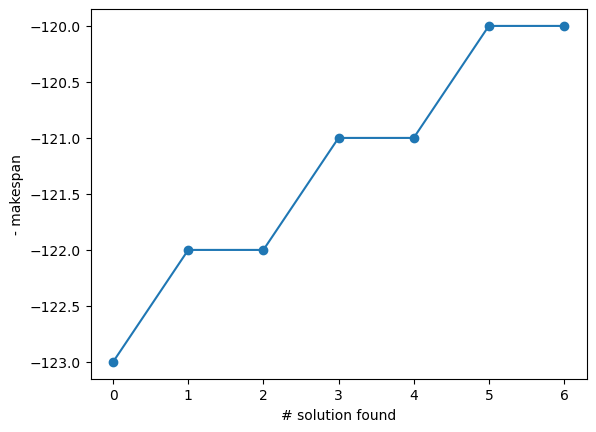

In [11]:
fig, ax = plt.subplots(1)
ax.plot([x[1] for x in results_hc.list_solution_fits], marker="o")
ax.set_ylabel("- makespan")
ax.set_xlabel("# solution found")
plt.show()

We improved a little bit the dummy solution :-)

## Simulated annealing
[Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) is an algorithm from the class of metaheuristics. It is a famous method to escape local optima of a function because contrary to the Hill Climbing algorithm, the current solution can be different from the current best solution. 
The algorithm is very similar to the HC one, except for the 3) step.

3) if $obj'<obj$ or $e^{\frac{obj-obj'}{T}}\geq random(0,1)$ then $(s, obj)\leftarrow (s',obj')$ 

when $obj'$ is greater than $obj$, the exponent of the exponential is negative. 
When $T$, the temperature setting is high, it is very likely that the $e^{\frac{obj-obj'}{T}}\geq random(0,1)$ inequality is satisfied and that we update our current solution $s$ even though $obj'>obj$.
To the contrary, with a low value $T$, we let less chance for $s'$ to be taken as new current solution. 

- Simulated annealing relies heavily on initial temperature setting and the cooling schedule, which makes the temperature $T$ evolve through the algorithms : in the beginning we can allow high temperature to allow more exploration of the solution space, and then decrease the temperature to focus more on optimisation. in the library it will be done with `TemperatureScheduling` object, that can be custom.
- For simulated annealing, the concept of `RestartHandler` makes sense : it consist in forcing the algorithm to go back to current best solution according to some criteria. Typically if there is no improvement for a given number of iteration, it can make sense to go back to current best solution

In [12]:
from discrete_optimization.generic_tools.ls.local_search import RestartHandlerLimit
from discrete_optimization.generic_tools.ls.simulated_annealing import (
    SimulatedAnnealing,
    TemperatureSchedulingFactor,
)

In [13]:
# Come back to best solution every 300 iteration without improvement.
restart_handler = RestartHandlerLimit(
    nb_iteration_no_improvement=300,
    cur_solution=dummy,
    cur_objective=-rcpsp_problem.evaluate(dummy)["makespan"],
)
# Multiply current temperature by a coefficient at every iteration. There might be better cooling schedule
# in the litterature.
temperature_scheduling = TemperatureSchedulingFactor(
    temperature=10, restart_handler=restart_handler, coefficient=0.9999
)

We can now define the simulated annealing solver : 

In [14]:
solver = SimulatedAnnealing(
    evaluator=rcpsp_problem,
    mutator=mixed_mutation,
    temperature_handler=temperature_scheduling,
    restart_handler=restart_handler,
    mode_mutation=ModeMutation.MUTATE_AND_EVALUATE,
)

In [15]:
results_sa = solver.solve(
    initial_variable=dummy, nb_iteration_max=10000, max_time_seconds=20
)

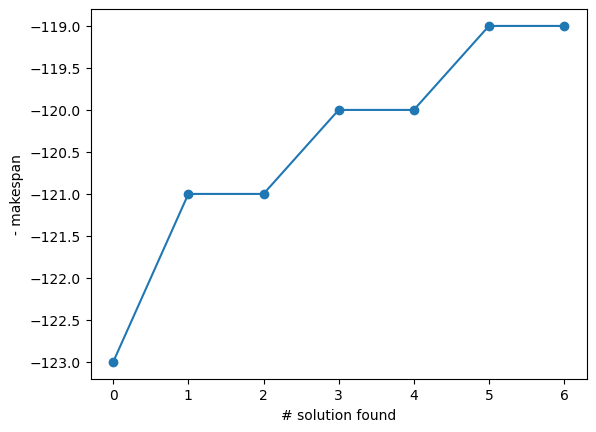

In [16]:
fig, ax = plt.subplots(1)
ax.plot([x[1] for x in results_sa.list_solution_fits], marker="o")
ax.set_ylabel("- makespan")
ax.set_xlabel("# solution found")
plt.show()

Depending on your luck, you might have found a better solution than using the hillclimbing ;).

Since RCPSP is a widely developed use case in `discrete-optimisation` we developed a wrapper around Hill climbing and simulated annealing to ease theur use : 

In [17]:
from discrete_optimization.rcpsp.solver.ls_solver import LS_SOLVER, LS_RCPSP_Solver

INFO:mip.model:Using Python-MIP package version 1.15.0


In [18]:
solver = LS_RCPSP_Solver(ls_solver=LS_SOLVER.HC, model=rcpsp_problem)
res = solver.solve(nb_iteration_max=10000, max_time_seconds=20)

In [19]:
print(res.get_best_solution_fit())

(<discrete_optimization.rcpsp.rcpsp_model.RCPSPSolution object at 0x00000193244BD820>, -114)


### Starting from a different initial solution
We can use the results of a greedy solver as the initial solution for local search algorithm : 

In [20]:
from discrete_optimization.rcpsp.solver.rcpsp_pile import GreedyChoice, PileSolverRCPSP

solver = PileSolverRCPSP(rcpsp_model=rcpsp_problem)
res_greedy = solver.solve(greedy_choice=GreedyChoice.MOST_SUCCESSORS)
print("res greedy : ", res_greedy.get_best_solution_fit())
solver = LS_RCPSP_Solver(ls_solver=LS_SOLVER.SA, model=rcpsp_problem)
res = solver.solve(
    nb_iteration_max=30000,
    max_time_seconds=20,
    starting_point=res_greedy.get_best_solution(),
)
print("local search : ", res.get_best_solution_fit())

res greedy :  (<discrete_optimization.rcpsp.rcpsp_model.RCPSPSolution object at 0x0000019322CAFD30>, -120)
local search :  (<discrete_optimization.rcpsp.rcpsp_model.RCPSPSolution object at 0x0000019322C9C280>, -114)


## Genetic algorithm

`discrete-optimization` provides wrapper solver to ```deap``` library solver implement evolutionnary algorithms. Genetic algorithms can be seen as a generalisation of previous algorithms, the difference being that the algorithms are now handling a population of solutions instead of only the current one. 
To generate the new population for the current one the genetic algorithm is decomposed in several step : 
- selection : which individuals should be selected for the next generation
- crossover : how to build new individuals from their parent (i.e the individual selected in the previous step)
- mutate : how the new individual from previous step can acquire some mutation (i.e local changes)

The genetic algorithm process is highly inspired by genetic selection and has been proven efficient for a wide range of optimisation problems.

In [21]:
from discrete_optimization.generic_tools.ea.ga import (
    DeapCrossover,
    DeapMutation,
    Ga,
    ObjectiveHandling,
)

Currently the API of `Ga` is a bit different than others solvers, we need to specify the attribute of our object solution that we consider as a vector representation of the solution : in our case "rcpsp_permutation", we also have to specify manually what is the objective function we want to maximize.

In [22]:
mutation = DeapMutation.MUT_SHUFFLE_INDEXES
crossover = DeapCrossover.CX_UNIFORM_PARTIALY_MATCHED
ga_solver = Ga(
    rcpsp_problem,
    encoding="rcpsp_permutation",
    objective_handling=ObjectiveHandling.AGGREGATE,
    objectives=["makespan"],
    objective_weights=[-1],
    pop_size=50,
    max_evals=30000,
    mut_rate=0.1,
    crossover_rate=0.9,
    crossover=crossover,
    mutation=mutation,
)
results_ga = ga_solver.solve()

gen	nevals	avg    	std    	min 	max 
0  	0     	-155.32	12.9961	-183	-134
1  	46    	-149.9 	12.9433	-180	-131
2  	48    	-144.56	11.0257	-173	-131
3  	48    	-138.74	10.4896	-170	-127
4  	40    	-134.42	7.82072	-160	-127
5  	46    	-134.86	9.44248	-163	-126
6  	46    	-128.24	2.92274	-139	-126
7  	46    	-129.22	5.39366	-156	-126
8  	44    	-126.58	2.38403	-138	-126
9  	46    	-127.12	5.66265	-165	-126
10 	43    	-127.66	5.89444	-163	-126
11 	50    	-128.74	7.18278	-166	-126
12 	46    	-126.44	2.15555	-137	-126
13 	46    	-127   	4.21426	-151	-126
14 	42    	-127.22	4.1823 	-145	-126
15 	45    	-128.78	7.55325	-159	-126
16 	50    	-126.84	3.65163	-148	-126
17 	49    	-127.36	5.3057 	-149	-126
18 	40    	-127.74	4.67679	-148	-126
19 	44    	-126.98	3.50708	-145	-126
20 	43    	-129.12	7.94139	-160	-126
21 	44    	-126.18	1.01371	-133	-126
22 	45    	-126.98	3.19055	-141	-126
23 	46    	-127.1 	4.73392	-155	-126
24 	42    	-128.84	7.38474	-155	-126
25 	49    	-129.42	8.87714	-166	-126
2

## Conclusion

In this notebook we have shown 3 ways of optimizing the RCPSP problem using local search and evolutionnary algorithms. Most of those solvers are available for all implemented problem in `discrete-optimisation` as long as there is a vector representation of the solution that all those algorithms are able to optimize. The mentionned methods should not be discarded when you have a combinatorial optimisation problem, they're anytime solver and with the right parameters and mutations can become the most suited solution for your problem, especially when the problem is intractable with mathematical methods that we will discuss in next notebook.